In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', font_scale=1.3, palette='Set2')
%matplotlib inline
from sklearn import datasets
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import graphviz
import scipy.stats
import warnings
from tqdm import tqdm_notebook
import random
from collections import Counter
from sklearn.metrics import precision_score

In [2]:
category = pd.read_csv("BBC_News_Sample_Solution.csv")
train_data = pd.read_csv("BBC_News_Train.csv")
test_data = pd.read_csv("BBC_News_Test.csv")
X_train, X_valid, y_train, y_valid = train_test_split(train_data['Text'], train_data['Category'], test_size=0.2, random_state = 344286)

In [3]:
X_train.head()

567     circuit city gets takeover offer circuit city ...
1436    child access laws shake-up parents who refuse ...
155     japanese banking battle at an end japan s sumi...
1065    jobs growth still slow in the us the us create...
1067    west end to honour finest shows the west end i...
Name: Text, dtype: object

In [4]:
set(train_data['Category'])

{'business', 'entertainment', 'politics', 'sport', 'tech'}

<Figure size 1152x2160 with 0 Axes>

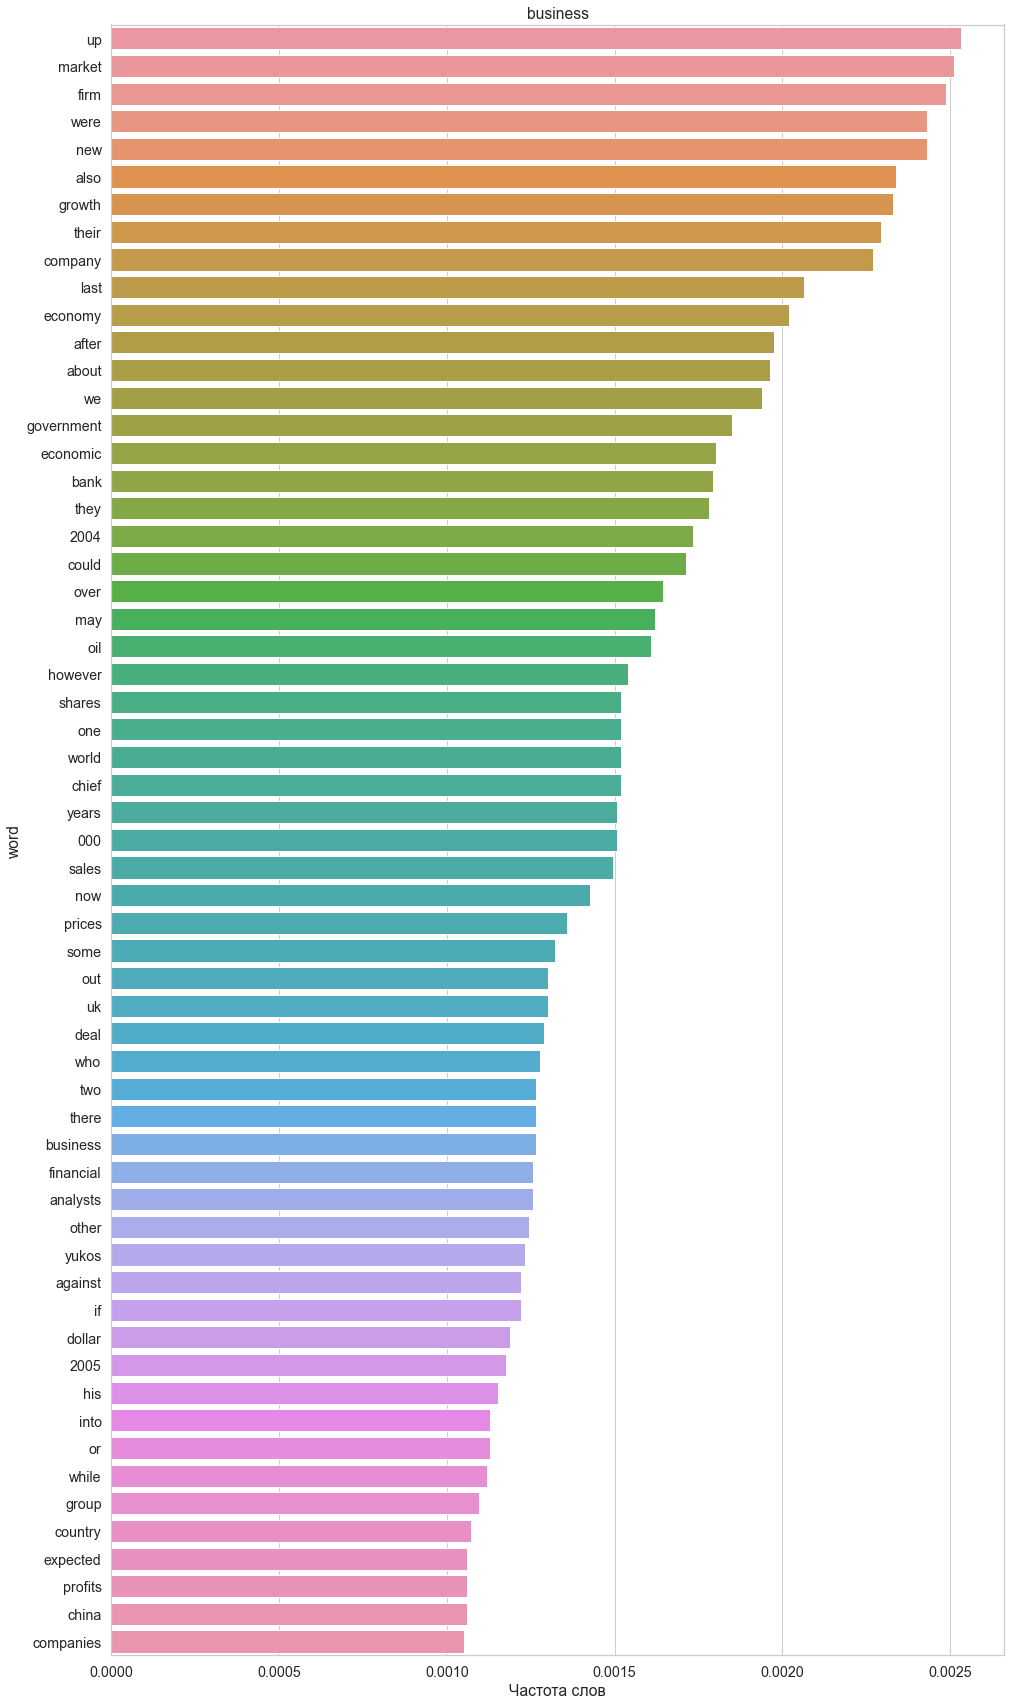

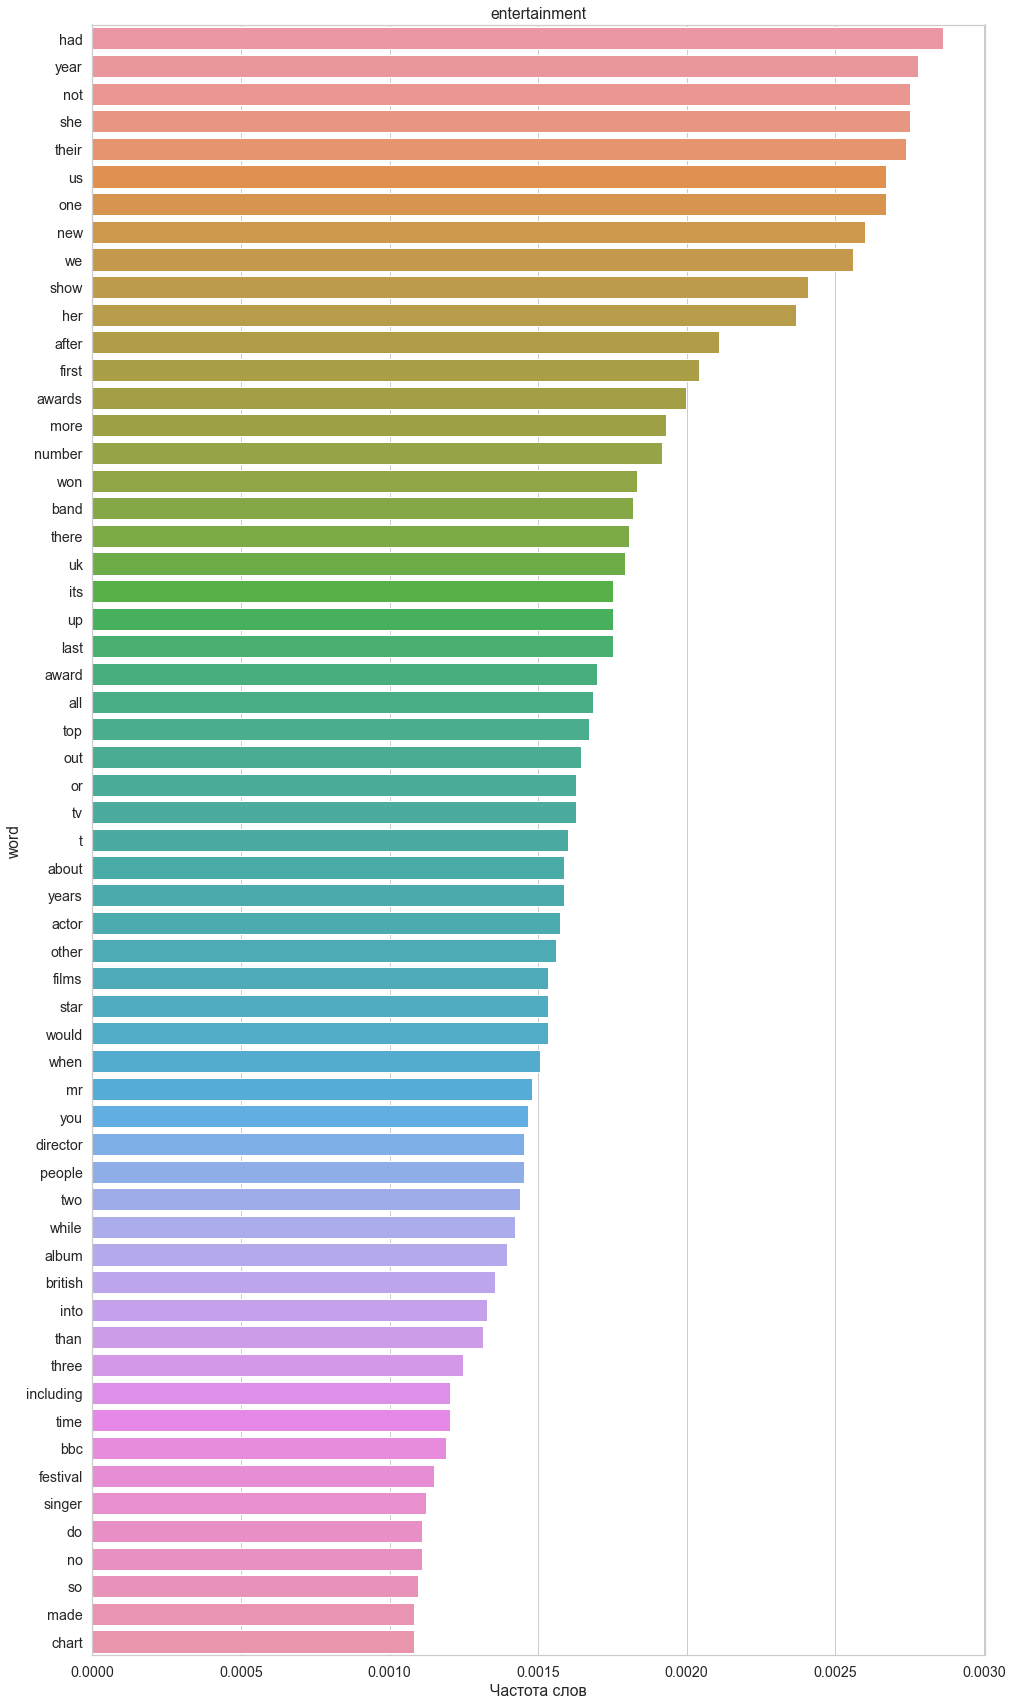

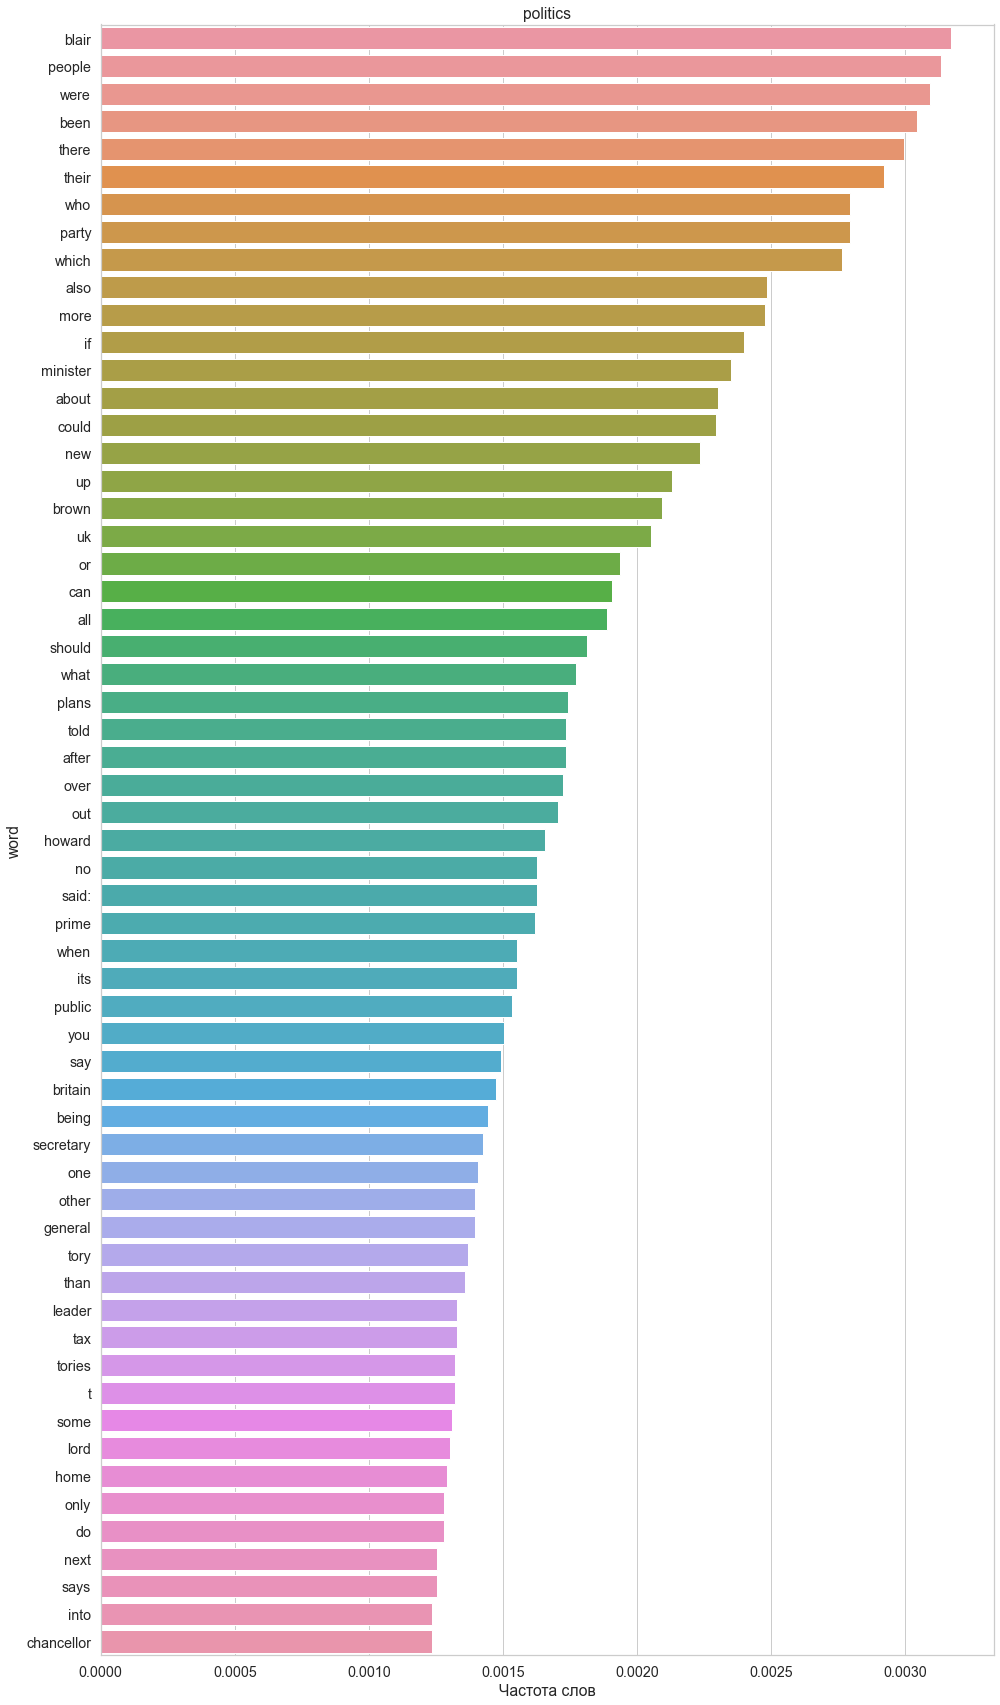

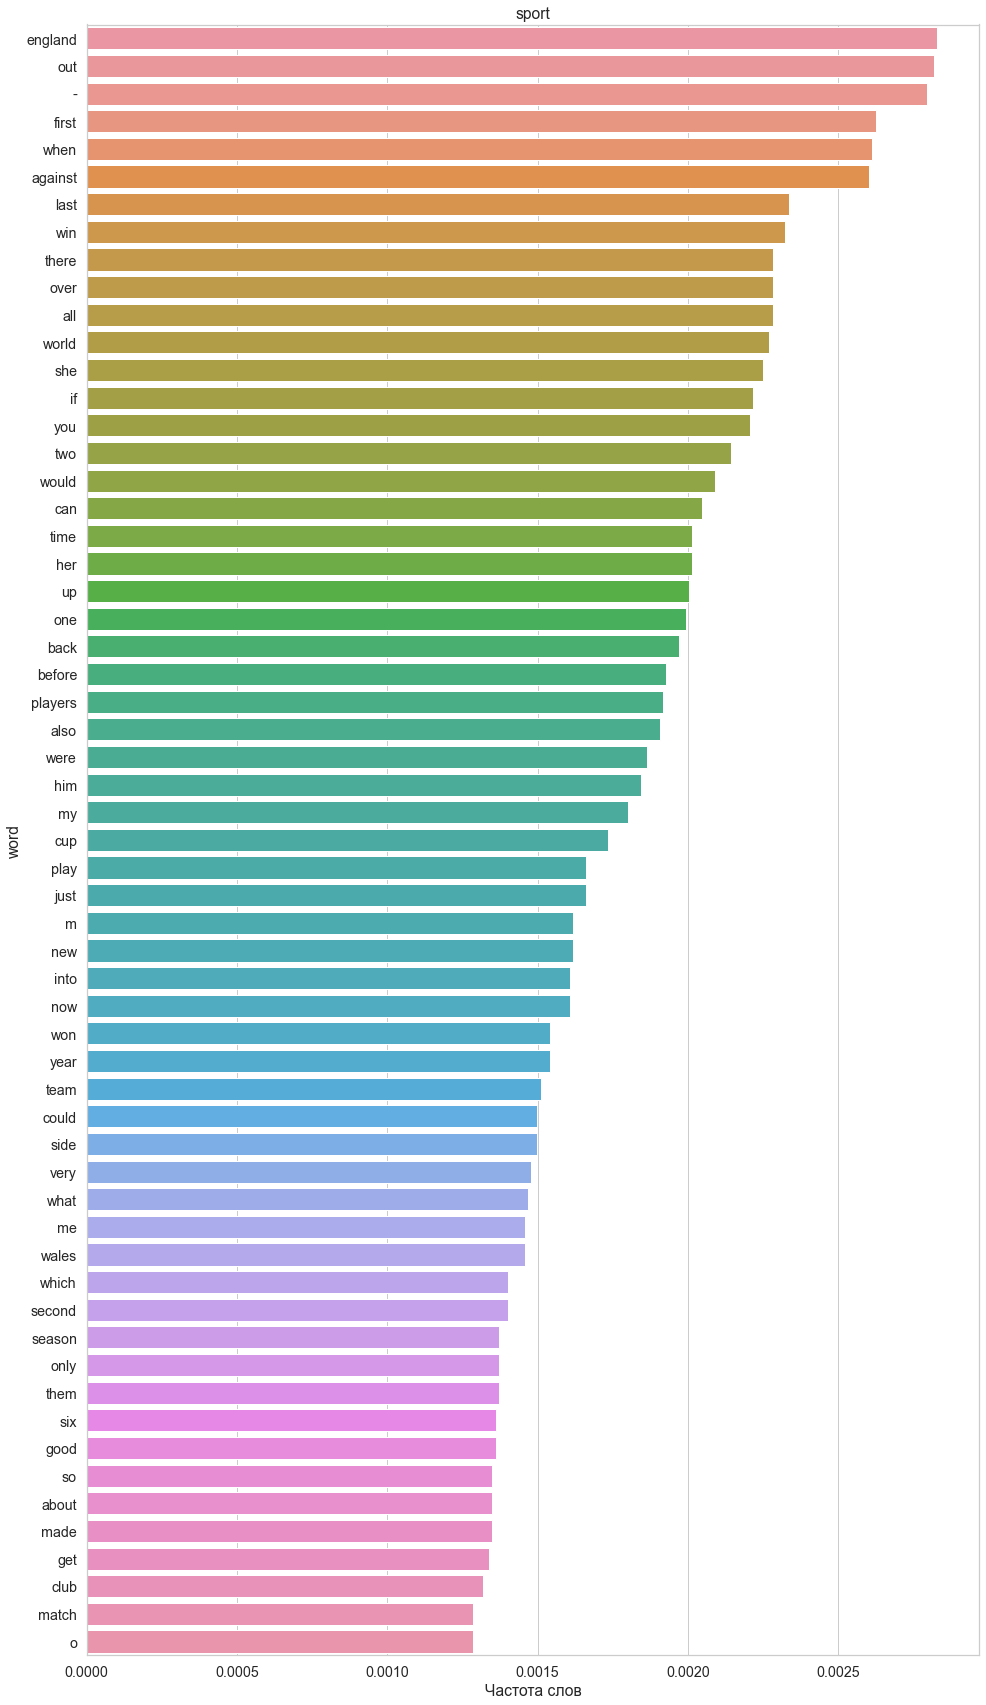

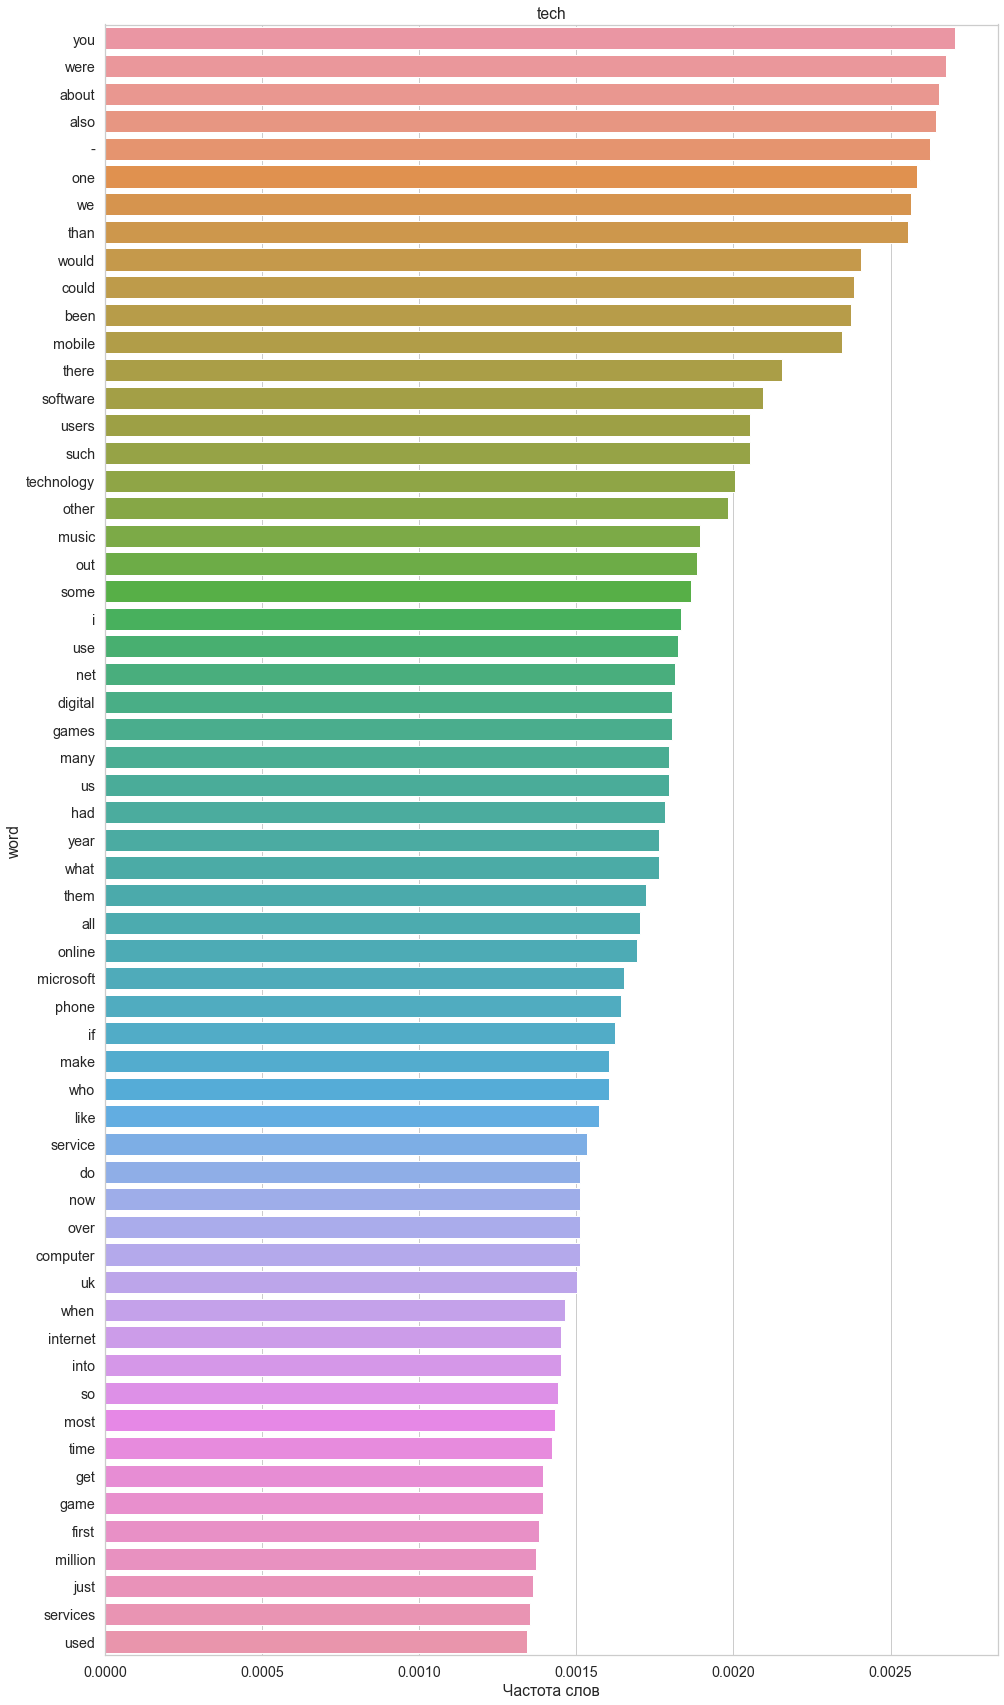

In [5]:
plt.figure(figsize=(16, 30))
bazis = pd.DataFrame()
bazis['word'] = ''
bazis['frec'] = 0
# для каждого класса
for  label in ['business', 'entertainment', 'politics', 'sport', 'tech']:
    # извлечем все сообщения и склеим их
    all_words = ' '.join(
        X_train[y_train == label]
    # приведем к нижнему регистру, удалим точки, разделим на слова
    ).lower().replace('.', '').split()
    # общее количество слов в этом классе
    words_count = len(all_words)

    # посчитаем встречаемость каждого слова и вернем топ-70
    counts = Counter(all_words).most_common(100)[40:-1]
    counts = pd.DataFrame(counts, columns=['word', 'count'])
    plt.figure(figsize=(16, 30))
    sns.barplot(y=counts['word'], x=counts['count']/words_count)
    counts['frec'] = counts['count'] / words_count
    counts = counts[['word', 'frec']]
    bazis = pd.concat([bazis, counts])
    plt.xlabel('Частота слов')
    plt.title(label)
    plt.show();

In [6]:
def handling_of_text(text, bazis):
    all_words = ' '.join(text).lower().replace('.', '').split()
    words_count = len(all_words)
    ans = list()
    counts = Counter(all_words)
    for i in list(bazis):
        ans.append(counts[i]/words_count)
    return ans

In [7]:
train_X_spec = []
for i in X_train:
    train_X_spec.append(handling_of_text(i, bazis['word']))

In [8]:
table_to_perevod = {'business' : 0, 'entertainment' : 1, 'politics' : 2, 'sport' : 3, 'tech' : 4}
table_to_perevod_obr = {0 : 'business', 1 : 'entertainment',  2 : 'politics',  3 : 'sport', 4 : 'tech'}
train_y_spec = list()
for i in y_train:
    train_y_spec.append(table_to_perevod[i])

In [9]:
model = RandomForestRegressor(n_estimators=500)
model.fit(train_X_spec, train_y_spec)

RandomForestRegressor(n_estimators=500)

In [10]:
valid_X_spec = []
for i in X_valid:
    valid_X_spec.append(handling_of_text(i, bazis['word']))

In [11]:
valid_y_spec = list()
for i in y_valid:
    valid_y_spec.append(table_to_perevod[i])

In [12]:
y_predict = model.predict(valid_X_spec)

In [13]:
mean_absolute_error(np.round(y_predict), valid_y_spec)

1.1879194630872483

In [14]:
dif = 0
for i in range(len(valid_y_spec)):
    dif += ( round(y_predict[i]) == valid_y_spec[i])
dif/len(valid_y_spec)

0.19463087248322147

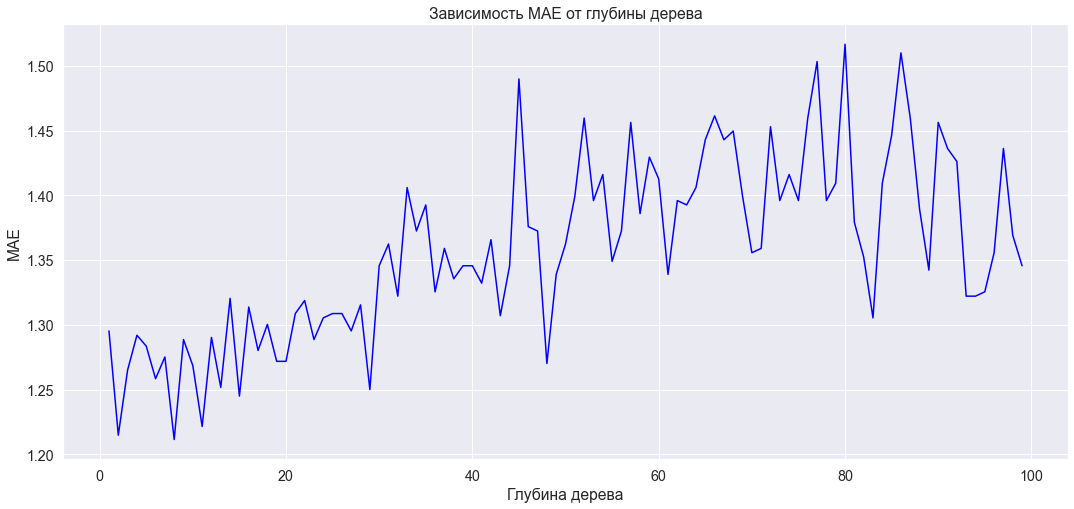

In [15]:
res = []
for i in range(1, 100):
    cycle_regressor = DecisionTreeRegressor(criterion='absolute_error', max_depth=i)
    cycle_regressor.fit(train_X_spec, train_y_spec)
    res.append(mean_absolute_error(cycle_regressor.predict(valid_X_spec), valid_y_spec))
sns.set_style("darkgrid")
fig2, ax2 = plt.subplots(figsize=(18, 8))
ax2.plot(range(1, 100), res, color="blue")
ax2.set_xlabel('Глубина дерева')
ax2.set_ylabel("MAE")
ax2.set_title("Зависимость MAE от глубины дерева")
plt.show()

In [16]:
model = DecisionTreeRegressor(criterion='absolute_error', max_depth=16)
model.fit(train_X_spec, train_y_spec)
y_predict = model.predict(valid_X_spec)
dif = 0
for i in range(len(valid_y_spec)):
    dif += ( round(y_predict[i]) == valid_y_spec[i])
dif/len(valid_y_spec)

0.3221476510067114

In [17]:
def predict(bazis, X):
    vec = []
    for i in range(5):
        vec.append(np.concatenate([np.zeros(59 * i), np.array(bazis[59 * i : 59 * (i + 1)]['frec']), np.zeros(59 * (4 - i))]))
    delta = []
    for i in range(5):
        delta.append(np.abs(X - vec[i]) @ np.array(bazis['frec']))
    min_el = min(delta)
    for i in range(5):
        if (min_el == delta[i]):
            return i


In [18]:
sum_of_win = 0
for i in range(len(valid_X_spec)):
    sum_of_win += predict(bazis, valid_X_spec[i]) == valid_y_spec[i]
print (sum_of_win / len(valid_X_spec))

0.23825503355704697
